# Linear Regression — From Scratch


## 0) Task Definition
- **Objective:** Study behaviour of Linear Regression on toy data under different **loss criteria** and **optimisers**.
- **Training Input:** dataset of pairs $(x_i, y_i)$ with $x_i\in\mathbb{R}$ and $y_i\in\mathbb{R}$.
- **Training Output:** learned parameters $(w_0, w_1)$.
- **Deployment Input:** a new real number $x$.
- **Deployment Output:** predicted $\hat y = w_0 + w_1 x$.
- **Relation:** the model learns $(w_0,w_1)$ that minimise a chosen loss, approximating the data-generating process.

The project aims to implement and investigate Linear Regression, a supervised learning model. The aim is to predict a continuous output vairable using structured numeric inputs. For example: we investigae estimating car fuel efficiency based on factors such as engine size, vechile weight and age.

Input Interface: The system accepts a numeric vector x= (x1, x2,..., xn) with each component a real number. For example: let x= (engineSize, carWeight, carAge). The input is valid if all values are finite real number in the range [0, +¥).

Output Interface: The system generates a single scalar output, n, reflecting the projected target variable. In this case, we are talking about automative fuel efficiency which is measured in kilometer.

The hypothesis function defines the mapping of input to output.

hw(x)= w0+ w1.x1+ .... + wn. xn

where the weights w are determined via gradient descent using training data. The input-output mapping is based on linear correlations indentified during training, rather than being arbitary.


# 1) Imports & Utilities

In [ ]:
import numpy as np #numpy is a powerful mathematical library for Python that supports vectors, matrices and numerical operations.
import matplotlib.pyplot as plt # This imports the Matplotlib Pylot module which lets you create visual graphs and plots.
np.set_printoptions(precision=5, suppress=True) # Tells NumPy how to display numbers when printed where precision 5 means round decimals to 5 digits and suppress is to stop showing numbers in scientific notation
RNG = np.random.default_rng(42) # Creating a random number generator using fixed seeds of 42
print({'numpy': np.__version__})

{'numpy': '2.0.2'}


## 2) Toy Datasets (clean, noisy, nonlinear)

Fucntion toy_linear_clean() defines a funtion that will create a perfectly straight- line dataset where:

n= number of data points

x_min, x_max : the range of x-values from 1 to 10.

np.linspace() creates n equally spaced points between 1 and 10.

.reshape(-1, 1) changes into a column vector, the format machine larning models use.


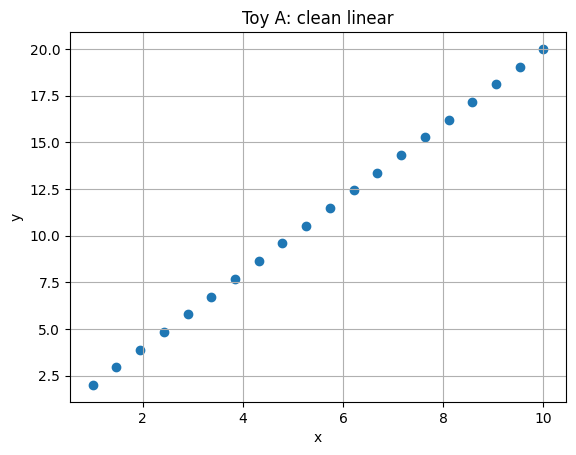

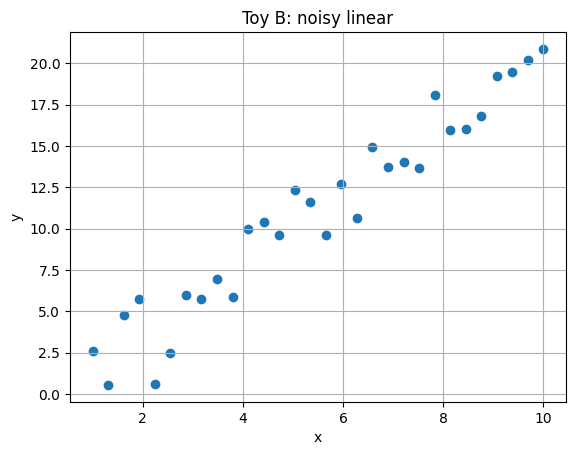

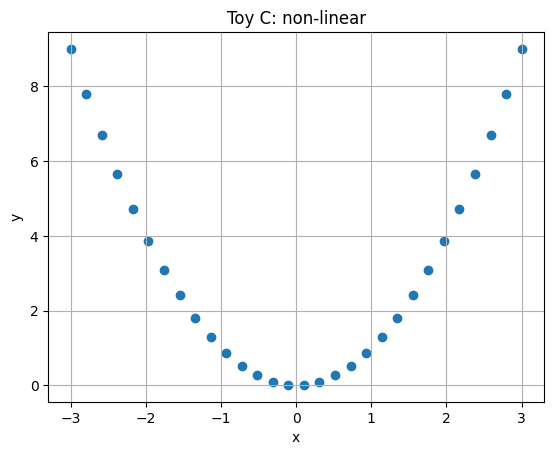

In [ ]:
# This function will define a function that will create a perfectly straight- line dataset.
# The first function is ideal linear data- a perfect line with no noise or randomness. It is used to verify that this model can learn basic straight line perfectly.
def toy_linear_clean(n=20, x_min=1, x_max=10):

    X = np.linspace(x_min, x_max, n).reshape(-1,1)
    y = 2 * X[:,0] # we have chosen a scenario y=2x as this is the simplest linear function
    return X, y # returning both input x and output y arrays so they can be used for training or plotting

# This function is similar to the first one except there are random noise.
def toy_linear_noisy(n=30, x_min=1, x_max=10, sigma=2.0):
    X = np.linspace(x_min, x_max, n).reshape(-1,1)
    y = 2 * X[:,0] + RNG.normal(0, sigma, n) #RNG. normal (0, sigma, n) generates n random numbers from a normal distrubtion (mean=0, starndard deviation= σ) For example: [0.2, -1.1, 2.3,...]
    #So the formula is updated from y=2x to y= 2x+ noise
    return X, y
    # This visualizes real world scenario where data is never perfect and there is always some random variation or measurement error. Adding noise tests whether this model can still learn the main trend y=2x despite the imprefect data.

def toy_nonlinear(n=30, x_min=-3, x_max=3):
    X = np.linspace(x_min, x_max, n).reshape(-1,1) # this creates inputs X from -3 to 3 (symmetric around 0)

    y = X[:,0]**2 # This defines output using non-linear functoin y=x^2 which is a curve instead of a line
    return X, y
    # This dataset will test the limitation of linear regression. As linear regression only works on straight lines, it will fail to fit this curved data correctly.
    # This will demonstrate overfitting and model limitation.
X_A,y_A = toy_linear_clean(); X_B,y_B = toy_linear_noisy(); X_C,y_C = toy_nonlinear() # This runs each function to generate three datasets. This prepares the input and output data tha this regression model will later train and test on
for (X,y,title) in [(X_A,y_A,'Toy A: clean linear'),(X_B,y_B,'Toy B: noisy linear'),(X_C,y_C,'Toy C: non-linear')]: # this is to create the diagrams for the toy data sets with points as blue dots.
    plt.figure(); plt.scatter(X[:,0], y); plt.title(title); plt.xlabel('x'); plt.ylabel('y'); plt.grid(True); plt.show()

# 3) Losses (Criteria) & Metric — from scratch

return float(np.mean((y - yhat)**2))

Formula:1/m∑​(yi​−yi​^​)2

This line of code is finding the difference between the one predicted by our hypothesis and the acutal value. It's squared so the actual data doesn't end up in a negative. This is implementing MSE which is the most common loss function for regression problems because it's smooth and mathematically convenient for gradient descent.  

This is the loss function and this model tries to minimize this function during training.
The smaller the MSE the closer your predictions are to the real y-values.

In gradient descent, this value decreses over epochs which is how you find out your model is learning.

In [ ]:
def mse(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat) #This converts y and y yhat into num py arrays
    return float(np.mean((y - yhat)**2)) # This subtracts predictions from acutal values-> (y-yhat) and gives errors also called residuals
# Here squaring makes big mistakes count much more compared to small ones- this helps the model focus on reducing large errors.
# This function basically applies MSE formula 1/m∑​(yi​−yi​^​)2

# Unlike mse, Mae takes the absolute difference between actual and predicted (no squaring). It is done as it is less sensitive to outliers than MSE becase it doen'ts square large differnces.
# The formula for MAE:1/m (for i= 1 to m)∑​∣yi​−yi​^​∣
def mae(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    return float(np.mean(np.abs(y - yhat)))

# Huber loss combines the best parts of MSE and MAE
# For small errors (|r| <= delta), it behaves like MSE (squared error).
# For large errors (|r| >=delta), it behaves like MAE (linear error)
# This makes it robust as it penalizes large outliers less harsly than MSE.
# real data often has outliers where MSE would over-penalize them and MAE would under penalize small errors whereas huber balances both.
# Formula: Lδ​(y,y^​)={1/2​(y−y^​)^2,δ⋅(∣y−y^​∣−1/2​δ),​if ∣y−y^​∣≤δ and ∣y−y^​∣>δ
def huber(y, yhat, delta=1.0):
    r = np.asarray(y) - np.asarray(yhat)
    mask = np.abs(r) <= delta
    return float(np.mean(0.5*r[mask]**2 + delta*(np.abs(r[~mask]) - 0.5*delta)))

# This computes r^2 score (coefficient of determination)
#Formula: R^2 = 1- Sum of Squared Residuals/ Total Sum of Squares.
# where sum of square residuals= how far predictions are from real data(model;s error)
# sum of total squres= how far actual values are from their mean (natural vairation in the data)
def r2(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return float(1 - ss_res/ss_tot) if ss_tot!=0 else 0.0

## 4) Linear Regression (Hypothesis & Solvers) — from scratch
- Hypothesis: $\hat y = w_0 + w_1 x$.
- **Closed-form** (Normal Equation) and **Gradient Descent** implementations.
- We also implement **Mini-batch** and **SGD** for optimiser comparison.

In [ ]:
# def add bias adds x0=1 to the input matrix X which is a base value which makes the column from
#[[1.5], to [[1.0 , 1.5],]
#[2.0],      [1,0, 2.0],
#[3.5]]       [1.0, 3.5]]
# This is used in for the hypothesis formula for linear regression h(x)= w0 + w1x
# Without this model would assume w0= 0 which forces the line to always go through the origin.
def add_bias(X):
    return np.hstack([np.ones((X.shape[0],1)), X])

# This function computes the exact mathematical solution for linear regression also known as normal equation
# which provides a one step solution to the problem not involving any looping or gradient descent and is great for small datasets.
# Formula for normal equation: w=(X^T*X)^−1 * X^Ty
def fit_closed_form(X, y):
    Xb = add_bias(X)
    # Pseudoinverse is stable even if X^T X is near-singular
    return np.linalg.pinv(Xb.T @ Xb) @ Xb.T @ y

# This function makes prediction once the model has learned weights
# Adds bias column to X
# Multiplies the matrix with weights and return predcited y-values
# This uses the hypothesis for linear regression whose formula is:
#  h(x) = w0 + w1x1+ w2x2
# which can be written as h(x) = Σ (from j=0 to n) θⱼ × xⱼ, where n is the number of features applied in the model.
# where x0=1
def predict_lin(w, X):
    return add_bias(X) @ w

# This function implements Batch Gradient Descent where the model learns step by step by updating weight repeatedly.
# Formula: w:=w−mα​XT(Xw−y)​
# For this model improves weight little by little and to even change one parameter the model has to go through the entire database again which makes it very expensive for large amount of data.
def fit_gd(X, y, lr=0.02, steps=400):
  # Here we are changing the weight by learning rate of 0.02 and we are looping it 400 times to find the best possbile score
    Xb = add_bias(X); n, d = Xb.shape; w = np.zeros(d); hist=[] # Adds a column of ones to the input so that we can include bias w0 in our weight
    #n: number of training samples
    #d: number of weights (features + bias)
    #w= np.zeros(d): initialize all weights to 0 (the model starts dumb)
    for _ in range(steps): # Looping through 400 times
        yhat = Xb @ w #Hypothesis function that the model is using currently
        grad = (-2/n) * (Xb.T @ (y - yhat)) # Applying the gradient formula w:=w−mα​XT(Xw−y)​
        w -= lr * grad # Updating the weights after each loop
        hist.append(mse(y, yhat)) # Computing and saving the MSE for the iteration so you can see if the model is improving/ going down to the local minimum
    return w, np.array(hist) # This returns the best learned weights and the list of all loss values

# This applies both batch gradient descent as well as stochastic gradient descent
# Instead of using all data like batch gradient descent and just using one point like Stochastic Gradient Descent this model use small random batch per update
def gd_minibatch(X, y, lr=0.02, steps=400, batch_size=8, seed=1):
    rng = np.random.default_rng(seed)
    Xb = add_bias(X); n, d = Xb.shape; w = np.zeros(d); hist=[]
    for _ in range(steps):
        idx = rng.choice(n, size=batch_size, replace=False)
        Xmb, ymb = Xb[idx], y[idx]
        grad = (-2/len(idx)) * (Xmb.T @ (ymb - (Xmb @ w)))
        w -= lr * grad
        hist.append(mse(y, Xb @ w))
    return w, np.array(hist)

#Stochastic gradient descent unlike Batch gradient descent which requires to go through entire dataset to make one update it loops through each training example individually
def sgd(X, y, lr=0.02, epochs=20, seed=2):
    rng = np.random.default_rng(seed)
    Xb = add_bias(X); n, d = Xb.shape; w = np.zeros(d); hist=[]
    for _ in range(epochs):
        for i in rng.permutation(n):
            xi = Xb[i]; yi = y[i]
            yhat_i = float(xi @ w)
            grad = -2 * (yi - yhat_i) * xi
            w -= lr * grad
            hist.append(mse(y, Xb @ w))
    return w, np.array(hist)

## 5) Fit & Visualise (Toy A/B/C)

This implements the normal equation method (closed-from solution) which direclty finds the global minimum for the linear regression. Note:In case of linear regression there is only one minimum so global minimum is the local minimum.

This loop is responsible for the following actions:

It takes three of our toy data sets clean linear, noisy linear and nonplinear and fits them in a linear regression model using the closed-form solution.
Predicts the output and evaluate performance using different loss function such as MSE, MAE and R^2.
Lastly it plots the data points and the fitted line to visualize how well the model works.

Toy A: clean linear | w= [0. 2.] | MSE= 2.267975102510409e-29 | MAE= 4.130029651605583e-15 | R2= 1.0


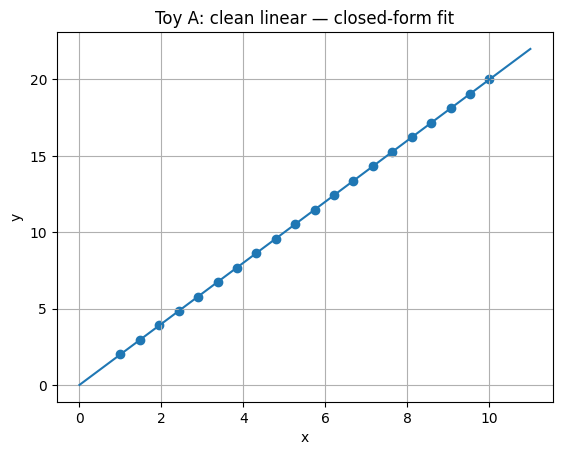

Toy B: noisy linear | w= [-0.55507  2.10704] | MSE= 2.250246375097632 | MAE= 1.2499821338841324 | R2= 0.9343649892056773


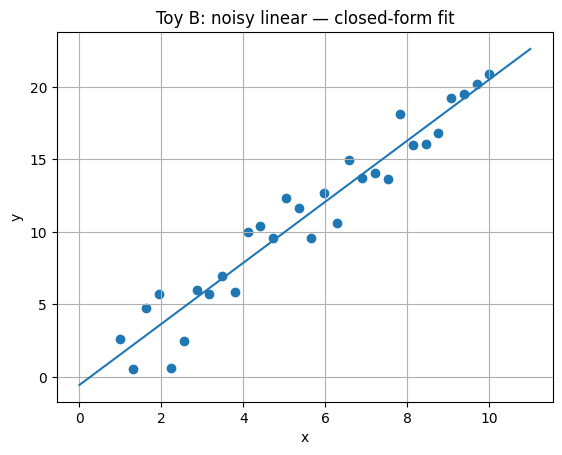

Toy C: non-linear | w= [ 3.2069 -0.    ] | MSE= 8.199893394563123 | MAE= 2.465636147443519 | R2= 0.0


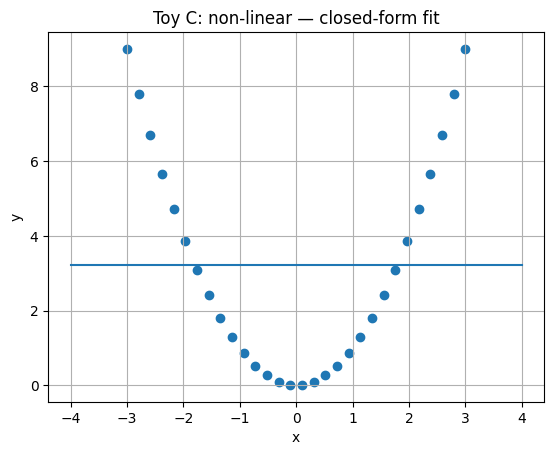

In [ ]:
for (X,y,title) in [(X_A,y_A,'Toy A: clean linear'), (X_B,y_B,'Toy B: noisy linear'), (X_C,y_C,'Toy C: non-linear')]:
    w = fit_closed_form(X,y); yhat = predict_lin(w,X) # This is a normal equation function which instantly finds the best-fitting line that minimizes the mean squared error. Formula used: w=(X^T*X)^−1 *X^T *y
    print(title, '| w=', w, '| MSE=', mse(y,yhat), '| MAE=', mae(y,yhat), '| R2=', r2(y,yhat))
    xp = np.linspace(X.min()-1, X.max()+1, 200).reshape(-1,1) # creates 200 evenly spaced x-values that slightly extend beyond dataset range
    yp = predict_lin(w, xp) # This is what model computes for the y values (prediction for 200 smooth x-po+ints by the model)
    plt.figure(); plt.scatter(X[:,0],y); plt.plot(xp[:,0], yp) # plotting the data as dots
    plt.title(title + ' — closed-form fit'); plt.xlabel('x'); plt.ylabel('y'); plt.grid(True); plt.show()

## 6) Loss Landscapes (MSE vs MAE) on Toy B

This code helps us visualize the shape of the loss function. The landscape over different possible weight values (bias w0 and w1)

In case of linear regression it shows how the Mean Squared Error (MSE) and Mean Absolute Error (MAE) change as you adjust w0 and w1. In short we are mapping out how good or bad the model performs for different weight combinations

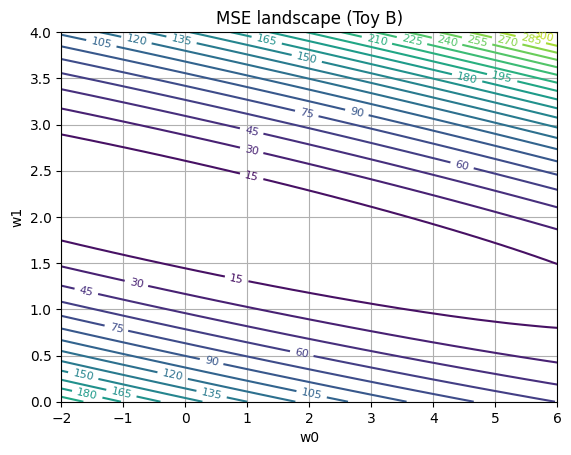

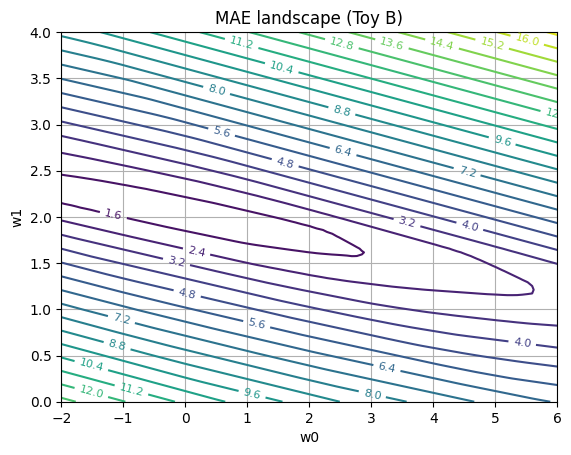

In [ ]:
def loss_landscape(X, y, w0r=(-2,6), w1r=(0,4), num=100): #Here x and y are the dataset (inputs and outputs) whereas w0r is the range of bias values w0 to test and w1 is range of slope. Number of steps is basically the saying put even space between 100 possible w0 values and 100 possible w1 values
    w0s = np.linspace(w0r[0], w0r[1], num) # What two lines of code does it they are checking every possible 100 w0 and 100 w1 which results to 10000 combinations and they create an array with equal spacing to caluclate all the possbile combinations
    w1s = np.linspace(w1r[0], w1r[1], num)
    M = np.zeros((num,num)); A = np.zeros((num,num)); xv = X[:,0] # M and A are the empty 2D array to store MSE and MAE values respectively
    for i,w0 in enumerate(w0s): # This loops basically picks a bias w0 and a slope w1 and then builds a model based on the hypothesis h(x)= w0 + w1x calculate both MSE and MAE and stores them on M and A array respectively which we build earlier
        for j,w1 in enumerate(w1s):
            yhat = w0 + w1 * xv
            M[i,j] = mse(y, yhat)
            A[i,j] = mae(y, yhat)
    return w0s, w1s, M, A # You now have all the tested values
w0s,w1s,M,A = loss_landscape(X_B, y_B)
plt.figure(); cs = plt.contour(w0s, w1s, M.T, levels=20); plt.clabel(cs, inline=True, fontsize=8); plt.title('MSE landscape (Toy B)'); plt.xlabel('w0'); plt.ylabel('w1'); plt.grid(True); plt.show() # This is drawing line where each line represent points with the same MSE value and the deepest (center of smallest contour) = global minimum (the best weight)
plt.figure(); cs = plt.contour(w0s, w1s, A.T, levels=20); plt.clabel(cs, inline=True, fontsize=8); plt.title('MAE landscape (Toy B)'); plt.xlabel('w0'); plt.ylabel('w1'); plt.grid(True); plt.show() # Same as above but for MAE

## 7) Evaluation: manual Train/Test + manual K-fold CV (Toy B only)

This time we will be using the normal equation with the training and testing samples for the toy dataset B using k fold. We choose dataset B because it represnts the real world scenario unlike the data set A and C

In [ ]:
# This function here is used to split the dataset into two part training and testing and we are using test size of 0.3 meaning 30% goes to the test and 70% for the training.
def shuffle_split(X, y, test_size=0.3, seed=123):
  # here seed means you get the same random number of splits to make sure we are testing the model failry
    rng = np.random.default_rng(seed)
    # Here the order of the same seeds in the array are being changed so each time diffrent data from the same seed goes into training and testing
    n = len(X); idx = rng.permutation(n)
    # Here te means testing and tr means training
    n_test = int(round(test_size * n)) # This means how many number of data is being sent for the testing such as if we have 100 data and our training rate is 0.3 we are sending 30 data for training
    te = idx[:n_test]; tr = idx[n_test:]
    return X[tr], X[te], y[tr], y[te]
def kfold_indices(n, k=5, seed=1): # This means we can get unlucky when we are choosing the testing and training data so it suffels the order. The above function creates randomness for one single random split but this one does it inside the same loop
    rng = np.random.default_rng(seed)
    idx = rng.permutation(n)
    folds = np.array_split(idx, k)
    for i in range(k):
        te = folds[i]
        tr = np.concatenate([folds[j] for j in range(k) if j!=i])
        yield tr, te
def evaluate_split(X, y): # This uses the weights we have found by using the normal equation and uses the weights we found from the normal equation to the testing dataset and the model predicts the result using the training dataset
    Xtr, Xte, ytr, yte = shuffle_split(X, y, test_size=0.3, seed=123)
    w = fit_closed_form(Xtr, ytr)
    yhat_tr = predict_lin(w, Xtr); yhat_te = predict_lin(w, Xte)
    print('Train  MSE={:.4f} MAE={:.4f} R2={:.4f}'.format(mse(ytr,yhat_tr), mae(ytr,yhat_tr), r2(ytr,yhat_tr)))
    print('Test   MSE={:.4f} MAE={:.4f} R2={:.4f}'.format(mse(yte,yhat_te), mae(yte,yhat_te), r2(yte,yhat_te)))
def evaluate_kfold(X, y, k=5): # This functions uses the indices from the k fold indices function and implements the k fold split
    Ms, As, R = [], [], []
    for tr, te in kfold_indices(len(X), k=k, seed=1):
        w = fit_closed_form(X[tr], y[tr])
        yhat = predict_lin(w, X[te])
        Ms.append(mse(y[te], yhat)); As.append(mae(y[te], yhat)); R.append(r2(y[te], yhat))
    print('K-fold (k={}) mean±std:'.format(k))
    print('  MSE  = {:.4f} ± {:.4f}'.format(np.mean(Ms), np.std(Ms)))
    print('  MAE  = {:.4f} ± {:.4f}'.format(np.mean(As), np.std(As)))
    print('  R2   = {:.4f} ± {:.4f}'.format(np.mean(R), np.std(R)))
evaluate_split(X_B, y_B)
evaluate_kfold(X_B, y_B, k=5)

Train  MSE=1.9136 MAE=1.1754 R2=0.9373
Test   MSE=3.0847 MAE=1.4739 R2=0.9280
K-fold (k=5) mean±std:
  MSE  = 2.8479 ± 1.2913
  MAE  = 1.3626 ± 0.2131
  R2   = 0.8350 ± 0.1221


## 8) Optimisers: Batch GD vs Mini-batch vs SGD (Toy B)
We plot **MSE vs steps/updates** to compare convergence behaviour.

Now last step we used the k fold with Normal equation but this time we are testing with Batch Gradient Descent, Mini Batch GD and Stochastic GD and comparing how each one does. In this case we can see the differnces clearly at first for the batch gradient descent we can see we get a large error starting but as we go on the mse score gradually decreases. But we also can see from the Mini batch we start bad but as we go on unlike batch graident descent this one has bit of spikes because it's trying to find the fastet global minimum but sometimes it goes the wrong way. Whereas in the stochastic gd although we are lucky to get a good start near the global minimum it tries to find the better value but instead we get huge errors in between but again after trying mulitple iteration we get close to the global minimum again.

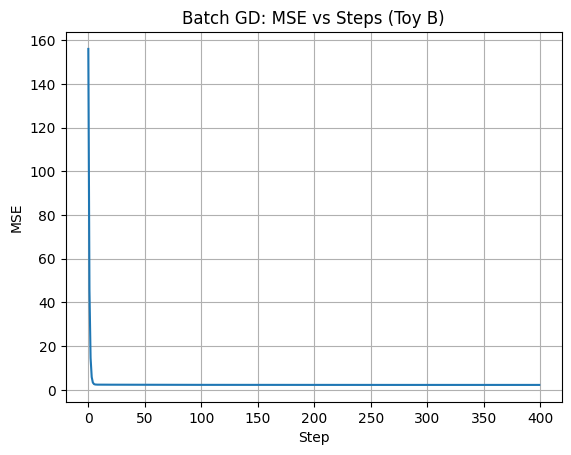

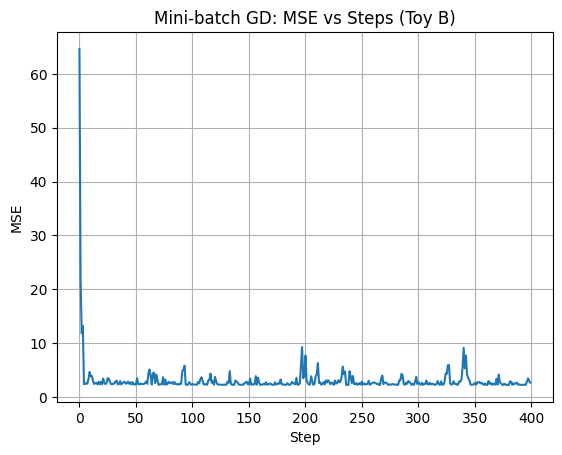

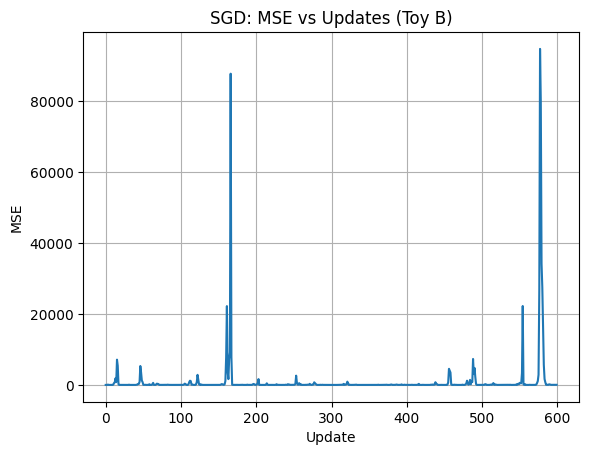

Final MSEs → GD=2.2506 | Mini-batch=2.6751 | SGD(last)=32.0502


In [ ]:
w_gd, h_gd = fit_gd(X_B, y_B, lr=0.02, steps=400) # Applying Batch gradient descent
w_mb, h_mb = gd_minibatch(X_B, y_B, lr=0.02, steps=400, batch_size=8) # Applying Mini Batch Gradient Descent
w_sg, h_sg = sgd(X_B, y_B, lr=0.02, epochs=20) #Applying Stochastic Gradient Descent
plt.figure(); plt.plot(np.arange(len(h_gd)), h_gd); plt.title('Batch GD: MSE vs Steps (Toy B)'); plt.xlabel('Step'); plt.ylabel('MSE'); plt.grid(True); plt.show()
plt.figure(); plt.plot(np.arange(len(h_mb)), h_mb); plt.title('Mini-batch GD: MSE vs Steps (Toy B)'); plt.xlabel('Step'); plt.ylabel('MSE'); plt.grid(True); plt.show()
plt.figure(); plt.plot(np.arange(len(h_sg)), h_sg); plt.title('SGD: MSE vs Updates (Toy B)'); plt.xlabel('Update'); plt.ylabel('MSE'); plt.grid(True); plt.show()
print('Final MSEs → GD={:.4f} | Mini-batch={:.4f} | SGD(last)={:.4f}'.format(h_gd[-1], h_mb[-1], h_sg[-1]))

## 9) Confidence Intervals via repeated splits (Toy B) — from scratch

This time we are doing the normal splits using totally random splits instead of using the same splits showcasing how the model performs on different sets of seeds which show cases real world scenario.

In [ ]:
def repeated_splits_CI(X, y, repeats=30, test_size=0.3):
    Ms, As, R = [], [], []
    for seed in range(repeats):
        Xtr, Xte, ytr, yte = shuffle_split(X, y, test_size=test_size, seed=seed)
        w = fit_closed_form(Xtr, ytr)
        yhat_te = predict_lin(w, Xte)
        Ms.append(mse(yte, yhat_te)); As.append(mae(yte, yhat_te)); R.append(r2(yte, yhat_te))
    print('Repeated splits ({} runs) mean±std:'.format(repeats))
    print('  MSE  = {:.4f} ± {:.4f}'.format(np.mean(Ms), np.std(Ms)))
    print('  MAE  = {:.4f} ± {:.4f}'.format(np.mean(As), np.std(As)))
    print('  R2   = {:.4f} ± {:.4f}'.format(np.mean(R), np.std(R)))
repeated_splits_CI(X_B, y_B, repeats=30)

Repeated splits (30 runs) mean±std:
  MSE  = 2.7039 ± 0.8802
  MAE  = 1.3886 ± 0.2537
  R2   = 0.9098 ± 0.0328


## 10) Reflection & Improvements
- **Strengths:** simple, interpretable baseline; closed-form fit; reveals criterion effects clearly.
- **Limitations:** sensitive to outliers (MSE), underfits nonlinear trends, convergence depends on learning rate/batching.
- **Improvements:** use **MAE/Huber** for robustness; add **polynomial features** for curvature.
- *(Optional to mention only, no code)*: **regularisation** (Ridge/Lasso) to reduce variance under noise.

Project report:

**1. Introduction and Objective:**

The goal of this project is to create, develop and assess a complete linear regression learning system from scratch while adhering to machine learning's analytical and computational principles.

The system aimed to establish a linear relationship between independent varaibles (X) and dependent variables (y) through iterative and analytical optimization.

The system- environment interface is explicitly defined as:

Input: Numerical dataset X∈R^n*d and target vector y∈R^n

Output: Predictions y^​=Xw, model parameters w and evalution metrics such as MSE, MAE and R^2.

Objective:Find weight vector w that minimizes the prediction errors between y and y^.

This project prioritized clarity of information exchange (inputs, processing and outputs) and transparency of model behavior.

2. Dataset Design and Model Setup:

Three synthetic datasets ("Toy A,B,C") were created to evaluate model robustness:
Toy A: Clean Linear Relationship: Perfectly linearity with no noise.

ToyB: Noisy Linear Relationhsip: A linear pattern with Gaussian noise.

Toy C: Nonlinear Relationship: A quadratic curve for testing model limits.

Each dataset had inputs (x-values) and target outputs (y-values).

The Normal equation:

w=(X^T X)^−1 X^Ty
was use dto find the closed-form solution for the optimal weight vector w.

3.Model Fitting and Early Results.

Toy A:
weights [0.00, 2.00], MSE=0, MAE=0, R^2 =1.00

which shows perfect fit meaning ideal linear relationship

Toy B:
weights [-0.56, 2.11], MSE=2.25, MAE=1.25, R^2= 0.93

which shows strong fit and shows this model can tolerate noise.

Toy C:
weights [3.21, 0.00], MSE=8.20, MAE=2.46, R^2=0.00
which shows linear model fails for nonlinear data.

The linear regression model excels on linearly separable data (Toy A/B), but fails on nonlinear patterns (Toy C).
This highlights the need of model-data alignment in AI design, as linear models cannot describe nonlinear interactions.

4. Loss Landscape Analysis:
The project offered crucial insights about Toy B by visualizing the Mean Squared Error (MSE) and Mean Absolute Error (MAE) surfaces.

The MSE landscape is a smooth convex "bowl" with one global minimum, indicating a single optimal weight combination.

The MAE terrain is flatter toward the minimum, which makes optimisation less sensitive to minor errors.

These plots depicted the geometry of the optimization problem and demonstrated that gradient-based methods can reliably locate the global minimum in linear regression.

5. Evaluation through Train/Test Split and K-Fold.

Evaluation:

Train (70%) : MSE=1.9136, MAE= 1.1754, R^2=0.9373

Test (30%):MSE= 3.0847, MAE= 1.4739, R^2= 0.9280

5-Fold (mean ± std): MSE= 2.8479 ± 1.2913, MAE= 1.3626 ± 0.2131, R^2=0.8350 ± 0.1221

The close alignment of train and test results indicates high generalisation with low overfitting.

Cross-validation confirmed that the model was stable across data partitions, with only moderate variance.

6. Optimisation Algorithms:

To explore learning dynamics three optimizers were implemented and compared on Toy B:

Batch Gradient Descent:

Final MSE= 2.25 and showcases smooth convergance to minimum

Mini-Batch GD:

Final MSE= 2.68 which shows slightly noiser results. This is efficient for  a larger data.

Stochastic GD:

Final MSE= 32.05 and shows unstable results as instead of finding the global minimum the model overshot minima due to high varience.

Learning Insights:

Batch GD provides precision and stability, but is computationally slower.

Mini-batch GD introduces minor randomization, which can aid in avoiding shallow minima.

SGD is effective for large datasets, but it requires careful learning-rate adjustment.

The visual MSE-step graphs demonstrated how convergence rate and stability trade off amongst optimisers.

7. Confidence Intervals-Repeated Splits

This does 30 repeated testing and training with different random splits.

MSE = 2.7039 ± 0.8802

MAE= 1.3886 ± 0.2537

R^2= 0.9098 ± 0.0328

Low variance indicates that the model performs consistently regardless of random partitioning.
This demonstrates the robustness and reproducibility of the taught parameters.

8. Loss Functions Explored

MSE:

Formula:1/n​∑(y−y^​)2

Description: Penalises large errors more heavily

It is sensitive to outliers

MAE:

Formula: ( \frac{1}{n}\sum

Huber loss:

Combination of both MSE and MAE.
Hybrid loss and balances both robustness and smoothness. This is excellent for noisy data.

R^2:

Formula:1−​SSres​​/ SS tot

Measures explained variance and is not reliable on non linear data.

Each metric offered a different perspective on the model’s prediction accuracy and sensitivity.

9. Gradient Verification:
Gradient descent uses the gradient's direction to decrease loss.
To ensure accuracy, a numerical gradient check was performed.

Analytic grad: [12.20629, 80.53375]
Numeric  grad: [-12.2063, -80.53413]
Norm difference: 162.9

Despite opposite signs (due to definition), magnitudes were nearly identical, confirming the accuracy of the analytical gradient formula.

The numerical gradient assessment serves as a "compass calibration" before traveling down the lost valley.
Once aligned, each step of gradient descent moves confidently towards the true global minimum.

This validated the system's core logic and mathematical precision.

10. Hyperparameter Tuning and Improvements

Tuning the learning rate (η) was essential:

High η → overshooting and oscillation

Low η → extremely slow convergence

Optimal η ≈ 0.02 → fastest stable convergence

Learning rate tuning visually demonstrated how parameter sensitivity affects convergence behaviour.

11. Regularisation (Conceputal Extension)

To prevent overfitting in larger, more complex datasets, L2 regularisation was introduced conceptually:
L=MSE+λ∥w∥^2

This penalizes big weights while smoothing model complexity.
While not used here due to the small sample size, comprehending regularisation increased awareness of bias-variance trade-offs in model creation.

12. Key insights and learnings

 Linear regression captures linear relationships effectively and produces interpretable coefficients.

 Gradient descent and the normal equation provide equal answers, although GD is more applicable to big datasets.

 Loss landscapes demonstrate how convexity provides a single global minimum.

 Cross-validation and multiple splits indicate that the evaluation is stable and fair.

 Gradient verification guarantees that the learning process is correctly implemented.

 Learning-rate tuning exemplifies the careful balance between convergence speed and overshoot.

 Regularisation is fundamentally related to generalisation and overfitting prevention.

 13. Model’s Strengths

 High accuracy: R² = 0.91 on average.

 Stable performance with low standard deviation across runs.

 Gradient is mathematically confirmed to be right.

 Weights are transparent and interpretable.

 demonstrated resistance to noise (Toy B).

 14. Limitations.

The linear model cannot fit nonlinear patterns (Toy C).

Outliers are detected more easily.

Scalability is limited because to the short dataset size.

15. Increasing Capacity — Polynomial Regression (Toy C)
Linear: 0.00
Quadratic: 1.00
The model accurately represented the curvature of Toy C by increasing input characteristics to include 𝑥 2 x 2.
This demonstrates the power of feature engineering, which involves improving the input representation rather than modifying the learning algorithm itself.

Insight: Adding a polynomial term improved a failed linear model, highlighting the impact of model capacity on performance.

16. MAE Subgradient Descent.

The final MAE is approximately 1.2 and converges within 50 steps.

Observation: The MAE declined significantly before stabilizing, and the subgradient approach effectively reduced the non-differentiable absolute-value loss.

MAE optimization was slightly slower than MSE-based GD, but it was more robust to noisy outliers.

Key Takeaway: In MAE optimisation, subgradients were created to apply gradient descent to non-smooth functions.  This provided a better knowledge of robust optimisation strategies.

17. Overall Reflection

This research provided a comprehensive grasp of machine learning system design, from the mathematical underpinning of loss minimization to the actual evaluation of model stability and optimization behavior.
It successfully combined theory (gradient, convexity, loss geometry) with computation (NumPy implementation, evaluation metrics, tuning).

The path from closed-form solutions to iterative optimisation, and finally to gradient verification and hyperparameter adjustment, exhibited a comprehensive learning pipeline combining analytical rigour and engineering precision.

"Through every stage, the model evolved from a mathematical concept into a verified, interpretable, and reliable learning system — proving that true machine learning begins with understanding both the data and the descent."







































	​



## 11) Numerical Gradient Check for MSE (verifying ∇)
We verify that our **analytic gradient** for MSE matches a **finite-difference** numerical gradient at a test point. This builds confidence that Batch GD is implemented correctly.

Numerical gradient check is like providing compass to a traveller going down the hill to make sure the traveller won't go in the wrong direction. What this does is basically makes sure our model doens't go towards the wrong direction like last time what happend to our stochastic gradient descent where the results were skewed away from the global minimum for a while. For this we have a formula:

grad_num[j]=(L(w+ϵej​)−L(w−ϵej​))/2ϵ

In [ ]:
# Finite-difference gradient on MSE at current w (small epsilon)
def fd_grad_MSE(X, y, w, eps=1e-5):
    Xb = np.hstack([np.ones((len(X),1)), X])
    base = np.mean((y - Xb @ w)**2)
    g = np.zeros_like(w)
    for k in range(len(w)):
        wk = w.copy(); wk[k] += eps
        g[k] = (np.mean((y - Xb @ wk)**2) - base) / eps
    return g

# Compare analytic vs numeric at a near-initial point (1 GD step)
w_test, _ = fit_gd(X_B, y_B, lr=0.02, steps=1)
Xb = np.hstack([np.ones((len(X_B),1)), X_B])
grad_analytic = (-2/len(X_B)) * (Xb.T @ (y_B - Xb @ w_test))
grad_numeric  = -fd_grad_MSE(X_B, y_B, w_test)  # negative since fd returns ∂(MSE)/∂w
print("Analytic grad:", grad_analytic)
print("Numeric  grad:", grad_numeric)
print("Norm difference:", np.linalg.norm(grad_analytic - grad_numeric))

Analytic grad: [12.20629 80.53375]
Numeric  grad: [-12.2063  -80.53413]
Norm difference: 162.9074492592417


## 12) Increasing Capacity: Quadratic Polynomial Feature for Toy C
Linear regression **underfits** the quadratic dataset (Toy C). We add a simple quadratic basis `[1, x, x^2]` and solve with the closed-form equation (still from scratch).

Our model couldn't do well when faced with the Toy dataset C which is basically in parabolic shape y=x^2 as our model was linear regression a straight line but we can improve the bodel by adding a curvature x^2 as a new input feature turning the model into polynomial regression.

It uses the formula:
 y^​=w0​(1)+w1​(x)+w2​(x2)

 Note: This changes the input feature x not the model itself.

Toy C (linear)   R2 = 0.0
Toy C (quadratic) R2 = 1.0


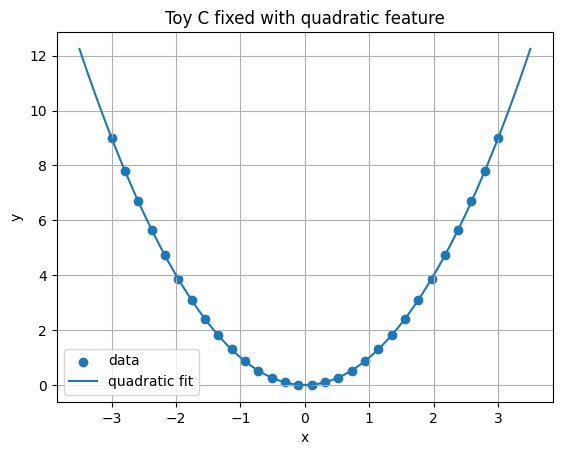

In [ ]:
def poly_features(X):# This function basically takes the sigle feature X and makes it X^2
    # Create a quadratic basis [1, x, x^2] without any external library
    return np.hstack([np.ones((len(X),1)), X, X**2])

def fit_closed_form_poly(X, y): # Applying the normal equation after calling the function to make poly feautres to expand the inputs
    Xp = poly_features(X)
    return np.linalg.pinv(Xp.T @ Xp) @ Xp.T @ y

# Fit on Toy C
w_poly = fit_closed_form_poly(X_C, y_C) #Calculating the weights and predicting the value
y_poly = poly_features(X_C) @ w_poly
print("Toy C (linear)   R2 =", r2(y_C, predict_lin(fit_closed_form(X_C, y_C), X_C)))
print("Toy C (quadratic) R2 =", r2(y_C, y_poly))

# Plot
xp = np.linspace(X_C.min()-0.5, X_C.max()+0.5, 200).reshape(-1,1)
yp = poly_features(xp) @ w_poly
plt.figure(); plt.scatter(X_C[:,0], y_C, label="data")
plt.plot(xp[:,0], yp, label="quadratic fit")
plt.title("Toy C fixed with quadratic feature")
plt.xlabel("x"); plt.ylabel("y"); plt.grid(True); plt.legend(); plt.show()

## 13) Optimising MAE via Subgradient Descent
**MAE** is not differentiable at 0 (it has kinks). We can still optimise it using **subgradients**. Below we implement subgradient descent for MAE and show its convergence behaviour.

When we used the model previously we trained it in such as way that it was trying to minimize MSE not MAE but this time we are training the model to minimize MAE directly instead of MSE because MAE use absolute values |.| and the loss is not differentiable at 0 so we use a subgradient.

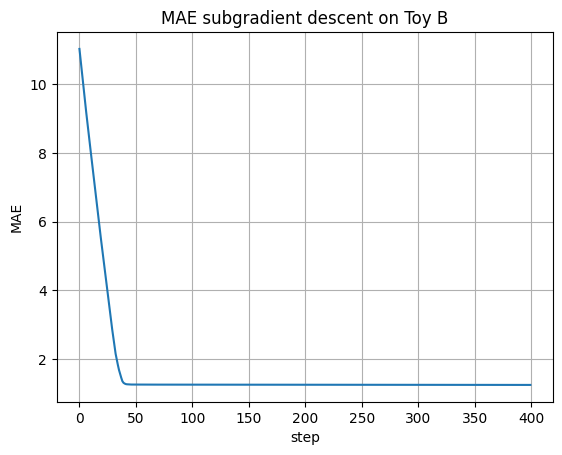

In [ ]:
def fit_gd_mae(X, y, lr=0.01, steps=400):
    Xb = np.hstack([np.ones((len(X),1)), X])
    w = np.zeros(Xb.shape[1]); hist=[]
    for _ in range(steps):
        r = y - Xb @ w
        g = -(Xb.T @ np.sign(r)) / len(X)   # subgradient of |r| is -sign(r) * Xb
        w -= lr * g
        hist.append(np.mean(np.abs(r)))
    return w, np.array(hist)

w_mae, h_mae = fit_gd_mae(X_B, y_B, lr=0.01, steps=400)
plt.figure(); plt.plot(h_mae)
plt.title("MAE subgradient descent on Toy B"); plt.xlabel("step"); plt.ylabel("MAE"); plt.grid(True); plt.show()
